In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so set the device to GPU
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print the name of the GPU device
else:
    # CUDA is not available, so set the device to CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA A30


In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import sentencepiece as spm
import torch
import json
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import datasets
import random
import math

In [2]:
dataset = datasets.load_dataset("roneneldan/TinyStories")

# Split the dataset into training and validation sets
train_dataset = dataset["train"]
val_dataset = dataset["validation"]


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [4]:
all_train_df = pd.DataFrame(train_dataset['text'])
all_val_df = pd.DataFrame(val_dataset['text'])

all_train_df.columns = ['text']
all_val_df.columns = ['text']


all_train_df.head(), all_val_df.head()

(                                                text
 0  One day, a little girl named Lily found a need...
 1  Once upon a time, there was a little car named...
 2  One day, a little fish named Fin was swimming ...
 3  Once upon a time, in a land full of trees, the...
 4  Once upon a time, there was a little girl name...,
                                                 text
 0  Spot. Spot saw the shiny car and said, "Wow, K...
 1  Once upon a time, in a big forest, there lived...
 2  Once upon a time, in a small yard, there was a...
 3  Once upon a time, there was a thoughtful girl ...
 4  Once upon a time, there was a kind farmer. He ...)

In [5]:
train_df = all_train_df[:1]
train_df

,text
0,"One day, a little girl named Lily found a need..."


In [6]:
def generate_inputs_and_labels(df, sp):
    inputs = []
    labels = []

    for index, row in df.iterrows():
        text = row['text']
        tokens = text.split()  # Tokenize the text by splitting on whitespace

        # Generate input by adding start of sentence token at the beginning
        input_sequence = tokens

        # Generate label by adding end of sentence token at the end
        label_sequence = tokens

        inputs.append(input_sequence)
        labels.append(label_sequence)

    # Convert input and label sequences to strings
    input_strings = [' '.join(sequence) for sequence in inputs]
    label_strings = [' '.join(sequence) for sequence in labels]

    # Tokenize input strings and add <sos> token at the beginning
    tokenized_inputs = []
    input_ids = []
    for sequence in input_strings:
        tokenized_sequence = sp.encode_as_pieces(sequence)
        tokenized_sequence = ['<sos>'] + tokenized_sequence  # Add <sos> token manually
        input_ids.append([sp.piece_to_id('<sos>')] + sp.encode_as_ids(sequence))  # Get token IDs
        tokenized_inputs.append(tokenized_sequence)

    # Tokenize label strings and add </sos> token at the end
    tokenized_labels = []
    label_ids = []
    for sequence in label_strings:
        tokenized_sequence = sp.encode_as_pieces(sequence)
        tokenized_sequence.append('</sos>')  # Add </sos> token manually at the end
        label_ids.append(sp.encode_as_ids(sequence) + [sp.piece_to_id('</sos>')])  # Get token IDs
        tokenized_labels.append(tokenized_sequence)

    # Print tokenized input and label sequences
    for i in range(len(inputs)):
        print("Input Text:", input_strings[i])
        print("Tokenized Input:", tokenized_inputs[i])
        print("Input IDs:", input_ids[i])
        print("\n")
        print("Label Text:", label_strings[i])
        print("Tokenized Label:", tokenized_labels[i])
        print("Label IDs:", label_ids[i])
        print("---------------------")

    return input_ids, label_ids


In [7]:
# Example usage
sp = spm.SentencePieceProcessor()
sp.load('small_m.model')

source_ids, target_ids = generate_inputs_and_labels(train_df, sp)

Input Text: One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt. Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt." Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
Tokenized Input: ['<sos>', '▁one', '▁day', ',', '▁a', '▁little', '▁girl', '▁name', 'd', '▁lily', '▁found', '▁a', '▁needle', '▁in', '▁her', '▁room', '.', '▁she', '▁knew', '▁it', '▁was', '▁difficult', '▁to', '▁play', '▁with', '▁it', '▁', 'because', '▁it', '▁was', '▁sharp', '.', '▁lily', '▁

# Transformer

### MultiHeadAttention

In [8]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

############################################################################

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
############################################################################

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        pe = self._init_pe(max_seq_length, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_length = x.size(1)
        pe = self.pe[:seq_length, :] if seq_length <= self.max_seq_length else self._init_pe(seq_length, self.d_model)
        return x + pe

    def _init_pe(self, seq_length, d_model):
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe
    
############################################################################

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
############################################################################

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, decoder_input, decoder_mask):
        attn_output = self.self_attn(decoder_input, decoder_input, decoder_input, decoder_mask)
        x = self.norm1(decoder_input + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
############################################################################


class Transformer(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask

    def forward(self, decoder_input):
        decoder_mask = self.generate_mask(decoder_input)
        decoder_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(decoder_input)))

        dec_output = decoder_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, decoder_mask)

        output = self.fc(dec_output)
        return output



In [9]:
# Convert lists to tensors
source_data = torch.tensor(source_ids)
target_data = torch.tensor(target_ids)

# Print shapes
print("Source data shape:", source_data.shape)
print("Target data shape:", target_data.shape)

print(source_data)
print(target_data)

Source data shape: torch.Size([1, 165])
Target data shape: torch.Size([1, 165])
tensor([[   0,   38,   28,    6,    8,   37,   53,   86,   34,   31,  119,    8,
         1614,   21,   14,  198,    3,   11,  185,   12,    9, 1455,    7,   54,
           24,   12,   19,  230,   12,    9, 1316,    3,   31,   59,    7,  259,
            4, 1614,   24,   14,   43,    6,   23,   11,   94, 2599,    8, 1293,
           32,   14,  802,    3,   31,   68,    7,   14,   43,    5,   18,    6,
           16,  749,    6,   49,  119,  149, 1614,    3,   66,   25,  259,   12,
           24,  145,    5, 2599,  140,  802,   82,   14,   43,   76,    5,   18,
            6,   16,  257,    6,   31,    6,   96,   66,  259,    4, 1614,    5,
          524,  129,  802,   46,  104,    6,   13,  678,    4, 1614,    5, 2599,
           20,    4, 1293,   32,   31,   17,   15,  802,    3,   12,    9,   60,
         1455,   36,   64,   19,  230,   13,   50, 1901,    5,  820,  183,  125,
            3,  167,   13,  5

In [23]:
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 512
max_seq_length = 100
dropout = 0.1
epochs = 1000

transformer = Transformer( tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)


criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

lossess = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = transformer(source_data)
    
    # Adjust target_data to have the same length as model output
    target_data_adjusted = target_data[:, :output.size(1)]
    
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), target_data_adjusted.contiguous().view(-1))
    lossess.append(loss)
    loss.backward()
    optimizer.step()
    if epoch%10==0 or epoch == 0 or epoch == epochs:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.728713989257812
Epoch: 11, Loss: 0.79233717918396
Epoch: 21, Loss: 0.09561437368392944
Epoch: 31, Loss: 0.016201868653297424
Epoch: 41, Loss: 0.005629836115986109
Epoch: 51, Loss: 0.0034210735466331244
Epoch: 61, Loss: 0.0017595504177734256
Epoch: 71, Loss: 0.0013070730492472649
Epoch: 81, Loss: 0.0010462588397786021
Epoch: 91, Loss: 0.000880131614394486
Epoch: 101, Loss: 0.0008216156857088208
Epoch: 111, Loss: 0.0007101529627107084
Epoch: 121, Loss: 0.0006273101316764951
Epoch: 131, Loss: 0.0005985501338727772
Epoch: 141, Loss: 0.0005261104088276625
Epoch: 151, Loss: 0.00047058743075467646
Epoch: 161, Loss: 0.00043098125024698675
Epoch: 171, Loss: 0.00039283098885789514
Epoch: 181, Loss: 0.0003671552403829992
Epoch: 191, Loss: 0.00034166150726377964
Epoch: 201, Loss: 0.00030909106135368347
Epoch: 211, Loss: 0.00028689816826954484
Epoch: 221, Loss: 0.0002626240602694452
Epoch: 231, Loss: 0.00023609347408637404
Epoch: 241, Loss: 0.00021129203378222883
Epoch: 251, Loss:

In [29]:
print(transformer)

Transformer(
  (decoder_embedding): Embedding(5000, 512)
  (positional_encoding): PositionalEncoding()
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=512, out_features=5000, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


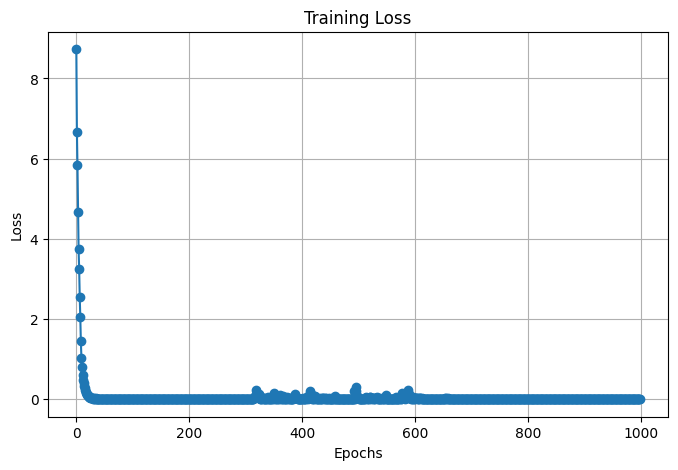

In [24]:
import matplotlib.pyplot as plt

# Assuming lossess is a list of PyTorch tensors
lossess = [l.detach().numpy() for l in lossess]  # Convert each tensor to NumPy array
epochs = [i for i, _ in enumerate(lossess)]  # Create epochs list

# Configure the plot
plt.figure(figsize=(8, 5))  # Set the plot size
plt.plot(epochs, lossess, marker='o', linestyle='-')  # Plot the data with markers and line
plt.xlabel('Epochs')  # Label the x-axis
plt.ylabel('Loss')  # Label the y-axis
plt.title('Training Loss')  # Set a title for the plot
plt.grid(True)  # Add a grid for better readability

# Show the plot
plt.show()

In [40]:
import sentencepiece as spm

def word_to_token_id(word, sp_model):
    # Convert word to token ID using SentencePiece
    return sp_model.piece_to_id(word)

def generate_text(model, sp_model, starting_word, ending_word, max_length):
    # Convert starting and ending words to token IDs
    starting_token_id = word_to_token_id(starting_word, sp_model)
    if starting_token_id is None:
        raise ValueError(f"Starting word '{starting_word}' not found in vocabulary.")
    ending_token_id = word_to_token_id(ending_word, sp_model)
    if ending_token_id is None:
        raise ValueError(f"Ending word '{ending_word}' not found in vocabulary.")
    
    generated_sequence = [starting_token_id]
    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.tensor([generated_sequence])
            output = model(input_tensor)
            predicted_token = output.argmax(-1)[:,-1].item()
            print(f"predicted_token is {predicted_token}")

            generated_sequence.append(predicted_token)
            print(f"generated_sequence is {generated_sequence}")
            if predicted_token == ending_token_id:
                break
            print("-------")
    
    # Convert token IDs to words using SentencePiece
    generated_text = sp_model.decode_ids(generated_sequence)
    return generated_text


# Example usage:
starting_word = "she"
ending_word = "</sos>"
max_length = 50
generated_sequence = generate_text(transformer, sp, starting_word, ending_word, max_length)


predicted_token is 8
generated_sequence is [2255, 8]
-------
predicted_token is 37
generated_sequence is [2255, 8, 37]
-------
predicted_token is 53
generated_sequence is [2255, 8, 37, 53]
-------
predicted_token is 86
generated_sequence is [2255, 8, 37, 53, 86]
-------
predicted_token is 34
generated_sequence is [2255, 8, 37, 53, 86, 34]
-------
predicted_token is 31
generated_sequence is [2255, 8, 37, 53, 86, 34, 31]
-------
predicted_token is 119
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119]
-------
predicted_token is 8
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119, 8]
-------
predicted_token is 1614
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119, 8, 1614]
-------
predicted_token is 21
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119, 8, 1614, 21]
-------
predicted_token is 14
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119, 8, 1614, 21, 14]
-------
predicted_token is 198
generated_sequence is [2255, 8, 37, 53, 86, 34, 31, 119, 8, 1614, 2

In [41]:
print("Generated sequence:", generated_sequence)

Generated sequence: she a little girl named lily found a needle in her room. she knew it was difficult to play with to play with it because it was sharp. lily wanted to share the needle with her mom, so she could sew a button on her shirt


In [30]:
"""

tgt_vocab_size = 5000
d_model = 64
num_heads = 8
num_layers = 6
d_ff = 512
max_seq_length = 100
dropout = 0.1
epochs = 100
starting_word = "lily"
ending_word = "</sos>"
max_length = 50


lily. can you share it was difficult to share the needle with her mom and sew my shirt. 
lily wanted to play with it because it was sharp. lily wanted to share the needle with 
her mom, so she could sew a button on her shirt


tgt_vocab_size = 5000
d_model = 512 (8 times more embeddings)
num_heads = 8
num_layers = 6
d_ff = 512
max_seq_length = 100
dropout = 0.1
epochs = 1000 (10 times more epochs)
starting_word = "lily"
ending_word = "</sos>"
max_length = 50


lily in her room. she could sew a little girl named lily found a needle in her mom for sharing play 
with it because it was sharp. lily wanted to her mom for sharing the needle with her mom, so she could sew a button on

# After 300 epochs, the model isnt learning much, and the difference is incomparable
# Time to scale up
"""

'\n\ntgt_vocab_size = 5000\nd_model = 64\nnum_heads = 8\nnum_layers = 6\nd_ff = 512\nmax_seq_length = 100\ndropout = 0.1\nepochs = 100\nstarting_word = "lily"\nending_word = "</sos>"\nmax_length = 50\n\n\nlily. can you share it was difficult to share the needle with her mom and sew my shirt. \nlily wanted to play with it because it was sharp. lily wanted to share the needle with \nher mom, so she could sew a button on her shirt\n\n\ntgt_vocab_size = 5000\nd_model = 512 (8 times more embeddings)\nnum_heads = 8\nnum_layers = 6\nd_ff = 512\nmax_seq_length = 100\ndropout = 0.1\nepochs = 1000 (10 times more epochs)\nstarting_word = "lily"\nending_word = "</sos>"\nmax_length = 50\n\n\nlily in her room. she could sew a little girl named lily found a needle in her mom for sharing play \nwith it because it was sharp. lily wanted to her mom for sharing the needle with her mom, so she could sew a button on\n\n# After 300 epochs, the model isnt learning much, and the difference is incomparable\n\n

In [28]:
# Save the trained model
#torch.save(transformer.state_dict(), 'transformer_model.pth')